In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from phase_2.scripts.strategies.trend.trend_strategy_v1 import run_trend_strategy_v1
from phase_2.scripts.strategies.meanrev.meanrev_strategy_v1 import run_meanrev_strategy_v1
from phase_2.scripts.strategies.meta.meta_allocator_v1 import build_regime_features

from phase_3.strategies.meta.meta_allocator_soft_v1 import (
    build_soft_meta_returns,
)


In [7]:
spy = pd.read_parquet("../../phase_2/data/processed/spy_daily.parquet")
spy["date"] = pd.to_datetime(spy["date"])
spy = spy.sort_values("date").reset_index(drop=True)
spy["year"] = spy["date"].dt.year

spy.head()


,date,open,high,low,close,adj_close,volume,year
0,2010-01-04,112.370003,113.389999,111.510002,113.330002,85.027946,118944600,2010
1,2010-01-05,113.260002,113.680000,112.849998,113.629997,85.253067,111579900,2010
2,2010-01-06,113.519997,113.989998,113.430000,113.709999,85.313049,116074400,2010
3,2010-01-07,113.500000,114.330002,113.180000,114.190002,85.673180,131091100,2010
4,2010-01-08,113.889999,114.620003,113.660004,114.570000,85.958290,126402800,2010


In [8]:
trend_out = run_trend_strategy_v1(
    spy,
    train_df=spy,   # same data; OK for smoke test
)

meanrev_out = run_meanrev_strategy_v1(
    spy,
)


In [9]:
regime = build_regime_features(spy)
regime.head()


,date,open,high,low,close,adj_close,volume,year,ret_1d,mom_20,mom_60,vol_20,drawdown_60
0,2010-01-04,112.370003,113.389999,111.510002,113.330002,85.027946,118944600,2010,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,113.260002,113.680000,112.849998,113.629997,85.253067,111579900,2010,0.002648,NaN,NaN,NaN,NaN
2,2010-01-06,113.519997,113.989998,113.430000,113.709999,85.313049,116074400,2010,0.000704,NaN,NaN,NaN,NaN
3,2010-01-07,113.500000,114.330002,113.180000,114.190002,85.673180,131091100,2010,0.004221,NaN,NaN,NaN,NaN
4,2010-01-08,113.889999,114.620003,113.660004,114.570000,85.958290,126402800,2010,0.003328,NaN,NaN,NaN,NaN


In [10]:
soft = build_soft_meta_returns(
    trend_out=trend_out,
    meanrev_out=meanrev_out,
    regime_df=regime,
)

soft.head()


,date,w_trend,w_meanrev,w_cash,meta_raw_ret
0,2010-01-04,0.0,0.0,1.0,0.0
1,2010-01-05,0.0,0.0,1.0,0.0
2,2010-01-06,0.0,0.0,1.0,0.0
3,2010-01-07,0.0,0.0,1.0,0.0
4,2010-01-08,0.0,0.0,1.0,0.0


In [11]:
# 1. No NaNs in weights
soft[["w_trend", "w_meanrev", "w_cash"]].isna().sum()
# 2. Weights sum to 1 (numerical tolerance)
weight_sum = soft["w_trend"] + soft["w_meanrev"] + soft["w_cash"]
(weight_sum - 1.0).abs().max()
# 3. Weights are in [0, 1]
soft[["w_trend", "w_meanrev", "w_cash"]].describe()

,w_trend,w_meanrev,w_cash
count,4025.000000,4025.000000,4025.000000
mean,0.280566,0.228014,0.491420
std,0.087732,0.063425,0.089603
min,0.000000,0.000000,0.261095
25%,0.232147,0.200134,0.452209
50%,0.294443,0.219501,0.479683
75%,0.340157,0.248659,0.504401
max,0.610619,0.509909,1.000000


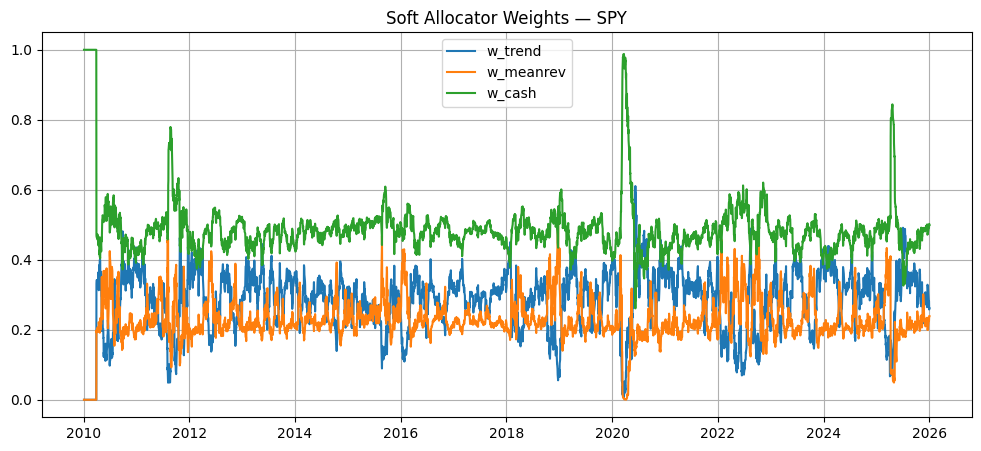

In [12]:
plt.figure(figsize=(12,5))
plt.plot(soft["date"], soft["w_trend"], label="w_trend")
plt.plot(soft["date"], soft["w_meanrev"], label="w_meanrev")
plt.plot(soft["date"], soft["w_cash"], label="w_cash")
plt.title("Soft Allocator Weights — SPY")
plt.legend()
plt.grid(True)
plt.show()


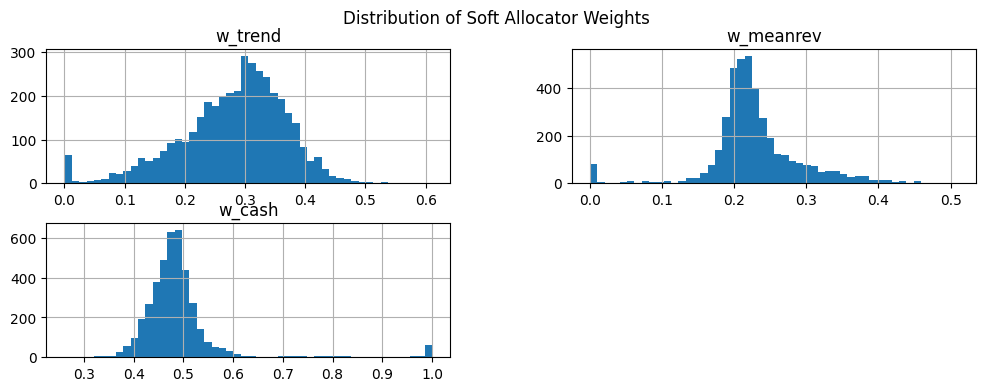

In [13]:
soft[["w_trend", "w_meanrev", "w_cash"]].hist(
    bins=50, figsize=(12,4)
)
plt.suptitle("Distribution of Soft Allocator Weights")
plt.show()
